# **Weather Classification**

## **ResNet**

**1. Tải bộ dữ liệu**

In [ ]:
# https://drive.google.com/file/d/1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0/view?usp=drive_link
!gdown --id 1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0
From (redirected): https://drive.google.com/uc?id=1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0&confirm=t&uuid=7cdff75b-8d60-4b62-9e54-0237b7c38c17
To: /content/img_cls_weather_dataset.zip
100% 613M/613M [00:07<00:00, 80.8MB/s]


In [ ]:
!unzip img_cls_weather_dataset.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: weather-dataset/dataset/frost/3922.jpg  
  inflating: weather-dataset/dataset/frost/3923.jpg  
  inflating: weather-dataset/dataset/frost/3924.jpg  
  inflating: weather-dataset/dataset/frost/3925.jpg  
  inflating: weather-dataset/dataset/frost/3926.jpg  
  inflating: weather-dataset/dataset/frost/3927.jpg  
  inflating: weather-dataset/dataset/frost/3928.jpg  
  inflating: weather-dataset/dataset/frost/3929.jpg  
  inflating: weather-dataset/dataset/frost/3930.jpg  
  inflating: weather-dataset/dataset/frost/3931.jpg  
  inflating: weather-dataset/dataset/frost/3932.jpg  
  inflating: weather-dataset/dataset/frost/3933.jpg  
  inflating: weather-dataset/dataset/frost/3934.jpg  
  inflating: weather-dataset/dataset/frost/3935.jpg  
  inflating: weather-dataset/dataset/frost/3936.jpg  
  inflating: weather-dataset/dataset/frost/3937.jpg  
  inflating: weather-dataset/dataset/frost/3938.jpg  
  inflating: weather-data

**2. Import các thư viện cần thiết**

In [ ]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

**3. Cố định giá trị ngẫu nhiên:** Để có thể tái tạo lại cùng một kết quả mô hình, chúng
ta sẽ cố định cùng một giá trị ngẫu nhiên (seed) cho các thư viện có chứa các hàm
tạo giá trị ngẫu nhiên:

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

**4. Đọc dữ liệu**

In [ ]:
root_dir = 'weather-dataset/dataset'
classes = {
    label_idx: class_name \
        for label_idx, class_name in enumerate(
            sorted(os.listdir(root_dir))
        )
}

img_paths = []
labels = []
for label_idx, class_name in classes.items():
    class_dir = os.path.join(root_dir, class_name)
    for img_filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_filename)
        img_paths.append(img_path)
        labels.append(label_idx)

**5. Chia bộ dữ liệu train, val, test**: Với danh sách đường dẫn ảnh và label, chúng ta
sẽ chia thành ba bộ dữ liệu train, val, test sử dụng hàm train_test_split() của thư
viện scikit-learn như sau:

In [ ]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_paths, labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

**6. Xây dựng class pytorch datasets:**

In [ ]:
class WeatherDataset(Dataset):
    def __init__(
        self,
        X, y,
        transform=None
    ):
        self.transform = transform
        self.img_paths = X
        self.labels = y

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
          img = self.transform(img)

        return img, self.labels[idx]

**7. Xây dựng hàm tiền xử lý ảnh (transform):** Để đảm bảo dữ liệu ảnh đầu vào
được đồng bộ về kích thước và giá trị, chúng ta tự định nghĩa hàm transform để tiền
xử lý ảnh đầu vào như sau (không sử dụng thư viện torchvision.transforms):

In [ ]:
def transform(img, img_size=(224, 224)):
    img = img.resize(img_size)
    img = np.array(img)[..., :3]
    img = torch.tensor(img).permute(2, 0, 1).float()
    normalized_img = img / 255.0
    return normalized_img

Các kỹ thuật được áp dụng: resize ảnh, đổi về tensor và chuẩn hóa giá trị pixel về
khoảng (0, 1).

**8. Khai báo datasets object cho ba bộ train, val, test:** Với class WeatherDataset
và hàm chuẩn hóa ảnh, ta tạo ba object datasets tương ứng như sau:

In [ ]:
train_dataset = WeatherDataset(
    X_train, y_train,
    transform=transform
)
val_dataset = WeatherDataset(
    X_val, y_val,
    transform=transform
)
test_dataset = WeatherDataset(
    X_test, y_test,
    transform=transform
)

**9. Khai báo dataloader:** Với ba object datasets trên, ta khai báo giá trị batch size và
tạo dataloader như sau:

In [ ]:
train_batch_size = 512
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

Feature batch shape: torch.Size([512, 3, 224, 224])
Labels batch shape: torch.Size([512])


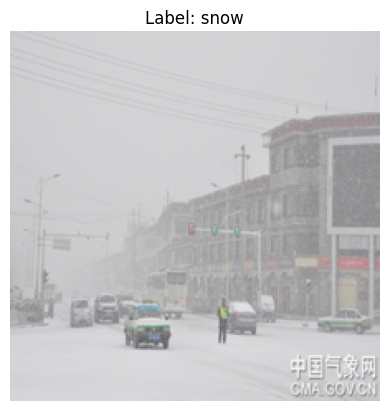

In [ ]:
train_features, train_labels = next(iter(train_loader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')
img = train_features[0].permute(1, 2, 0)
label = train_labels[0].item()
plt.imshow(img)
plt.axis('off')
plt.title(f'Label: {classes[label]}')
plt.show()

**10. Xây dưng model:** Trong phần này, chúng ta sẽ xây dựng class cho model deep
learning với kiến trúc ResNet.

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = stride),
                nn.BatchNorm2d(out_channels))
        self.relu = nn.ReLU()

    def forward(self, x):
        shortcut = x.clone()
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x += self.downsample(shortcut)
        x = self.relu(x)
        return x

Với ResidualBlock, ta triển khai toàn bộ kiến trục ResNet như sau:

In [ ]:
class ResNet(nn.Module):
    def __init__(self, residual_block, n_blocks_lst, n_classes):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.conv2 = self.create_layer(residual_block, 64, 64, n_blocks_lst[0], 1)
        self.conv3 = self.create_layer(residual_block, 64, 128, n_blocks_lst[1], 2)
        self.conv4 = self.create_layer(residual_block, 128, 256, n_blocks_lst[2], 2)
        self.conv5 = self.create_layer(residual_block, 256, 512, n_blocks_lst[3], 2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, n_classes)

    def create_layer(self, residual_block, in_channels, out_channels, n_blocks, stride):
        blocks = []
        first_block = residual_block(in_channels, out_channels, stride)
        blocks.append(first_block)
        for idx in range(1, n_blocks):
            block = residual_block(out_channels, out_channels, stride)
            blocks.append(block)
        block_sequential = nn.Sequential(*blocks)
        return block_sequential

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

In [ ]:
n_classes = len(list(classes.keys()))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ResNet(
    residual_block=ResidualBlock,
    n_blocks_lst=[2, 2, 2, 2],
    n_classes=n_classes
).to(device)

In [ ]:
model.eval()

dummy_tensor = torch.randn(1, 3, 224, 224).to(device)

with torch.no_grad():
    output = model(dummy_tensor)

print('Output shape:', output.shape)

Output shape: torch.Size([1, 11])


**11. Xây dựng hàm đánh giá model:** Ta xây dựng hàm đánh giá model với đầu vào
là model, bộ dữ liệu đánh giá và hàm loss. Hàm này sẽ trả về giá trị loss và accuracy
của model trên tập dữ liệu đầu vào:

In [ ]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

**12. Xây dựng hàm huấn luyện model:**

In [ ]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

    return train_losses, val_losses

**13. Khai báo hàm loss và thuật toán tối ưu hóa:** Với bài toán phân loại ảnh, ta sử
dụng hàm loss CrossEntropyLoss và thuật toán tối ưu hóa Stochastic Gradient
Descent (SGD). Ngoài ra, ta cũng khai báo giá trị learning rate và số epochs:

In [ ]:
lr = 1e-2
epochs = 25

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=lr
)

**14. Thực hiện huấn luyện:** Với tất cả các tham số đầu vào đã sẵn sàng, ta gọi hàm
fit() để bắt đầu quá trình huấn luyện mô hình ResNet:

In [ ]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
)

EPOCH 1:	Train loss: 1.9403	Val loss: 2.3931
EPOCH 2:	Train loss: 1.3235	Val loss: 2.4111
EPOCH 3:	Train loss: 1.0388	Val loss: 2.3727
EPOCH 4:	Train loss: 0.8413	Val loss: 1.9263
EPOCH 5:	Train loss: 0.7060	Val loss: 1.6169
EPOCH 6:	Train loss: 0.5566	Val loss: 1.1763
EPOCH 7:	Train loss: 0.4149	Val loss: 1.0530
EPOCH 8:	Train loss: 0.3071	Val loss: 1.4047
EPOCH 9:	Train loss: 0.2680	Val loss: 1.0276
EPOCH 10:	Train loss: 0.1748	Val loss: 1.0490
EPOCH 11:	Train loss: 0.1202	Val loss: 0.9585
EPOCH 12:	Train loss: 0.0866	Val loss: 0.9609
EPOCH 13:	Train loss: 0.0744	Val loss: 0.9590
EPOCH 14:	Train loss: 0.0619	Val loss: 0.9944
EPOCH 15:	Train loss: 0.0516	Val loss: 0.9511
EPOCH 16:	Train loss: 0.0461	Val loss: 0.9677
EPOCH 17:	Train loss: 0.0331	Val loss: 0.9494
EPOCH 18:	Train loss: 0.0306	Val loss: 0.9422
EPOCH 19:	Train loss: 0.0281	Val loss: 0.9484
EPOCH 20:	Train loss: 0.0233	Val loss: 0.9403
EPOCH 21:	Train loss: 0.0220	Val loss: 0.9521
EPOCH 22:	Train loss: 0.0192	Val loss: 0.96

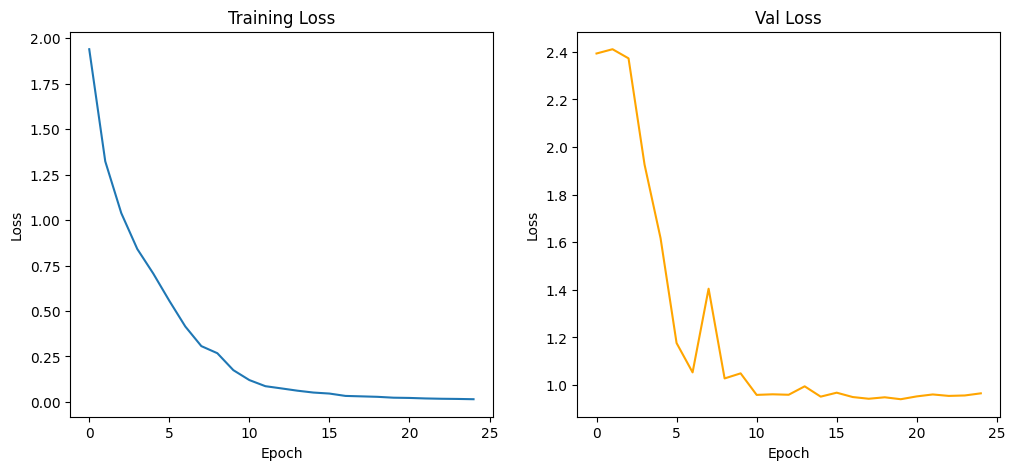

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

**15. Đánh giá mô hình:**

In [ ]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.7050254916241806
Test accuracy:  0.6466302367941712


# **Scenes Classification**

## **DenseNet**

**1. Tải bộ dữ liệu**

In [2]:
# https://drive.google.com/file/d/1ZUCuYDOe4VVbZvNVZovpquaRQqqJQ639/view?usp=sharing
!gdown --id 1ZUCuYDOe4VVbZvNVZovpquaRQqqJQ639

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ZUCuYDOe4VVbZvNVZovpquaRQqqJQ639
From (redirected): https://drive.google.com/uc?id=1ZUCuYDOe4VVbZvNVZovpquaRQqqJQ639&confirm=t&uuid=fe92aa71-54e3-44c7-aac9-0eef2de153c0
To: /content/img_cls_scenes_classification.zip
100% 255M/255M [00:04<00:00, 62.2MB/s]


In [3]:
!unzip img_cls_scenes_classification.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: scenes_classification/train/mountain/16162.jpg  
  inflating: scenes_classification/train/mountain/16173.jpg  
  inflating: scenes_classification/train/mountain/16225.jpg  
  inflating: scenes_classification/train/mountain/16322.jpg  
  inflating: scenes_classification/train/mountain/16341.jpg  
  inflating: scenes_classification/train/mountain/16350.jpg  
  inflating: scenes_classification/train/mountain/16374.jpg  
  inflating: scenes_classification/train/mountain/16375.jpg  
  inflating: scenes_classification/train/mountain/16417.jpg  
  inflating: scenes_classification/train/mountain/1642.jpg  
  inflating: scenes_classification/train/mountain/16421.jpg  
  inflating: scenes_classification/train/mountain/16438.jpg  
  inflating: scenes_classification/train/mountain/16560.jpg  
  inflating: scenes_classification/train/mountain/16599.jpg  
  inflating: scenes_classification/train/mountain/16645.jpg  
  inflating: s

**2. Import các thư viện cần thiết**

In [4]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

**3. Cố định giá trị ngẫu nhiên**

In [5]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

**4. Đọc dữ liệu**

So với bộ dữ liệu ở bài trước, ta đã được chia sẵn hai bộ dữ liệu train và val. Tuy
nhiên, để đồng bộ, chúng ta sẽ vẫn đi theo hướng code cũ. Đầu tiên, ta vẫn đọc danh
sách classes như sau:

In [6]:
root_dir = 'scenes_classification'
train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'val')

classes = {
    label_idx: class_name \
        for label_idx, class_name in enumerate(
            sorted(os.listdir(train_dir))
        )
}

X_train = []
y_train = []
X_test = []
y_test = []
for dataset_path in [train_dir, test_dir]:
    for label_idx, class_name in classes.items():
        class_dir = os.path.join(dataset_path, class_name)
        for img_filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_filename)
            if 'train' in dataset_path:
                X_train.append(img_path)
                y_train.append(label_idx)
            else:
                X_test.append(img_path)
                y_test.append(label_idx)

In [7]:
classes

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

**5. Chia bộ dữ liệu train, val, test:** Vì đã có sẵn bộ dữ liệu train và test, ta chỉ việc
chia thêm cho tập val từ tập train như sau:

In [8]:
val_size = 0.2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

**6. Xây dựng class pytorch datasets:**

In [9]:
class ScenesDataset(Dataset):
    def __init__(
        self,
        X, y,
        transform=None
    ):
        self.transform = transform
        self.img_paths = X
        self.labels = y

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
          img = self.transform(img)

        return img, self.labels[idx]

**7. Xây dựng hàm tiền xử lý ảnh (transforms):**

In [10]:
def transform(img, img_size=(224, 224)):
    img = img.resize(img_size)
    img = np.array(img)[..., :3]
    img = torch.tensor(img).permute(2, 0, 1).float()
    normalized_img = img / 255.0
    return normalized_img

**8. Khai báo datasets object cho ba bộ train, val, test:**

In [11]:
train_dataset = ScenesDataset(
    X_train, y_train,
    transform=transform
)
val_dataset = ScenesDataset(
    X_val, y_val,
    transform=transform
)
test_dataset = ScenesDataset(
    X_test, y_test,
    transform=transform
)

**9. Khai báo dataloader:** Lưu ý, với colab, các bạn nên cài đặt train batch size = 64
để có thể train được bài này.

In [12]:
train_batch_size = 64
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


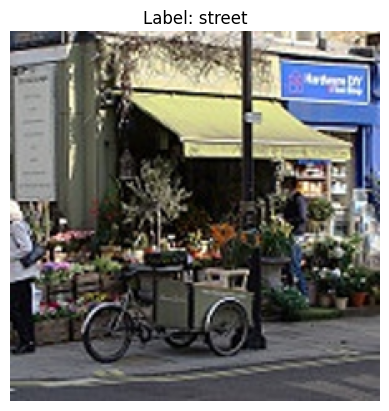

In [13]:
train_features, train_labels = next(iter(train_loader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')
img = train_features[0].permute(1, 2, 0)
label = train_labels[0].item()
plt.imshow(img)
plt.axis('off')
plt.title(f'Label: {classes[label]}')
plt.show()

**10. Xây dựng model:** Trong phần này, chúng ta sẽ xây dựng class cho model deep
learning với kiến trúc DenseNet.

In [14]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(BottleneckBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, 4 * growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4 * growth_rate)
        self.conv2 = nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)
        self.relu = nn.ReLU()
    def forward(self, x):
        res = x.clone().detach()
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = torch.cat([res, x], 1)
        return x

class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(num_layers):
            layers.append(BottleneckBlock(in_channels + i * growth_rate, growth_rate))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

Với DenseBlock, ta triển khai toàn bộ kiến trúc DenseNet như sau:

In [15]:
class DenseNet(nn.Module):
    def __init__(self, num_blocks, growth_rate, num_classes):
        super(DenseNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 2 * growth_rate, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(2 * growth_rate)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.dense_blocks = nn.ModuleList()
        in_channels = 2 * growth_rate
        for i, num_layers in enumerate(num_blocks):
            self.dense_blocks.append(DenseBlock(num_layers, in_channels, growth_rate))
            in_channels += num_layers * growth_rate
            if i != len(num_blocks) - 1:
                out_channels = in_channels // 2
                self.dense_blocks.append(nn.Sequential(
                    nn.BatchNorm2d(in_channels),
                    nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                    nn.AvgPool2d(kernel_size=2, stride=2)
                ))
                in_channels = out_channels
        self.bn2 = nn.BatchNorm2d(in_channels)
        self.pool2 = nn.AvgPool2d(kernel_size=7)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(in_channels, num_classes)
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)
        for block in self.dense_blocks:
            x = block(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

Sử dụng phiên
bản DenseNet-121

In [16]:
n_classes = len(list(classes.keys()))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = DenseNet(
    [6, 12, 24, 16],
    growth_rate=32,
    num_classes=n_classes
).to(device)

In [17]:
model.eval()

dummy_tensor = torch.randn(1, 3, 224, 224).to(device)

with torch.no_grad():
    output = model(dummy_tensor)

print('Output shape:', output.shape)

Output shape: torch.Size([1, 6])


In [18]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [19]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

    return train_losses, val_losses

**11. Khai báo hàm loss và thuật toán huấn luyện:** Với bài toán là phân loại ảnh, ta
cũng sẽ sử dụng hàm loss CrossEntropy và Stochastic Gradient:

In [20]:
lr = 1e-3
epochs = 15

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=lr
)

**12. Thực hiện huấn luyện:** Sử dụng hàm evaluate() và hàm fit() đã triển khai trong
bài trước, chúng ta sẽ huấn luyện model DenseNet như sau:

In [21]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
)

EPOCH 1:	Train loss: 1.7128	Val loss: 1.6425
EPOCH 2:	Train loss: 1.5935	Val loss: 1.5467
EPOCH 3:	Train loss: 1.5132	Val loss: 1.4797
EPOCH 4:	Train loss: 1.4556	Val loss: 1.4321
EPOCH 5:	Train loss: 1.4125	Val loss: 1.3943
EPOCH 6:	Train loss: 1.3767	Val loss: 1.3622
EPOCH 7:	Train loss: 1.3483	Val loss: 1.3372
EPOCH 8:	Train loss: 1.3206	Val loss: 1.3132
EPOCH 9:	Train loss: 1.3008	Val loss: 1.2941
EPOCH 10:	Train loss: 1.2810	Val loss: 1.2735
EPOCH 11:	Train loss: 1.2643	Val loss: 1.2612
EPOCH 12:	Train loss: 1.2494	Val loss: 1.2418
EPOCH 13:	Train loss: 1.2363	Val loss: 1.2305
EPOCH 14:	Train loss: 1.2204	Val loss: 1.2171
EPOCH 15:	Train loss: 1.2086	Val loss: 1.2056


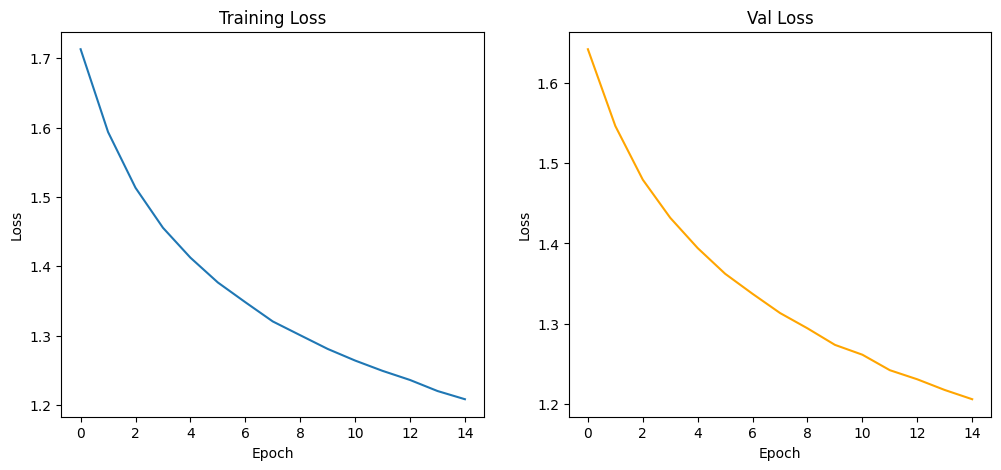

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

**13. Đánh giá model:** Ta gọi hàm evaluate() để đánh giá performance của model trên
hai tập val và test như sau:

In [23]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.5771286070537941
Test accuracy:  0.5613333333333334
